# Face tracking pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and tracking on an image dataset using MTCNN.

In [10]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw, ImageFont
from IPython import display
import os

#### Determine if an nvidia GPU is available

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [12]:
mtcnn = MTCNN(keep_all=True, device=device, image_size=128)
classes = ["masked", "masked_sunglasses", "neutral", "sunglasses"]

#### Get samples video

We begin by loading videos with some faces in it. The `mmcv` PyPI package by mmlabs is used to read the video frames (it can be installed with `pip install mmcv`). Frames are then converted to PIL images.

In [13]:

frames_list = []
for file in os.listdir("videos/"):
    video = mmcv.VideoReader("videos/"+file)
    frames_list.append([Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video])
    display.Video("videos/"+file, width=640)

#### Run video through MTCNN

We iterate through each frame, detect faces, and draw their bounding boxes on the video frames.

Video: masked.mp4
Tracking frame: 146

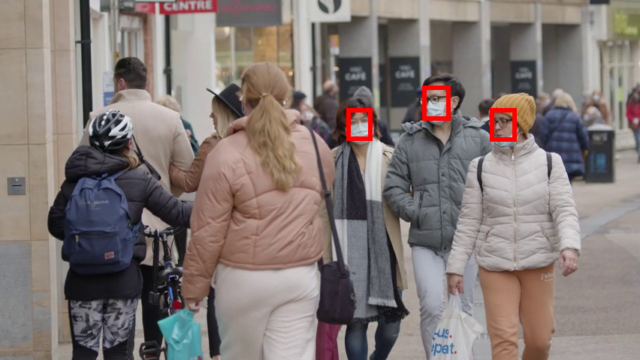

Video: masked_sunglasses.mp4
Tracking frame: 145

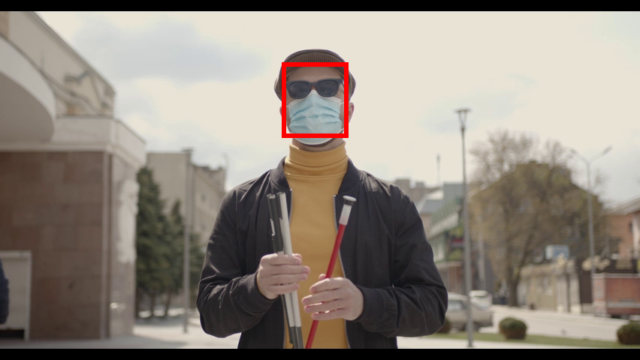

Video: neutral.mp4
Tracking frame: 105

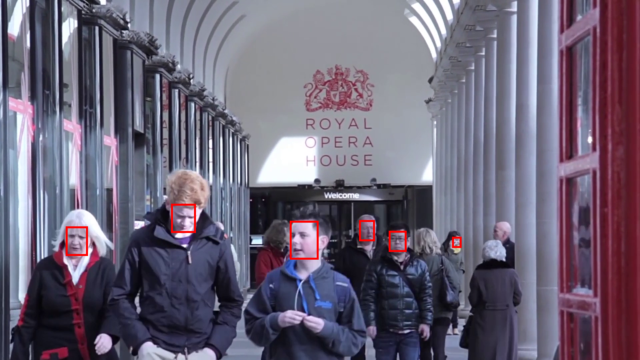

Video: sunglasses.mp4
Tracking frame: 127

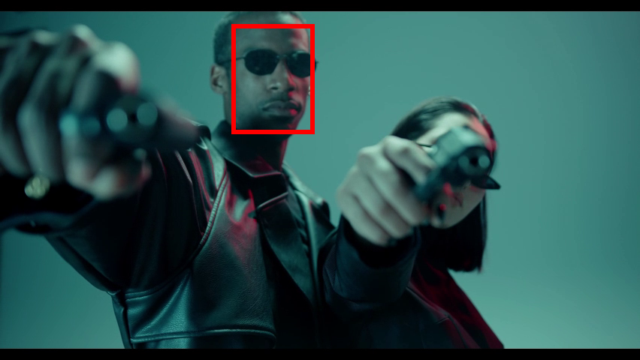


Done


In [14]:
for file in os.listdir("videos/"):
    video = mmcv.VideoReader("videos/"+file)
    frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
    frames_tracked = []

    print("Video: " + file)
    for i, frame in enumerate(frames):
        print('\rTracking frame: {}'.format(i + 1), end='')
        
        # Detect faces
        boxes, _ = mtcnn.detect(frame)

        # Save cropped images
        img = mtcnn(frame, save_path="detected/" + file[0:-4] + "/" + str(i) + ".jpg")
        
        # Draw faces
        frame_draw = frame.copy()
        draw = ImageDraw.Draw(frame_draw)
        if(boxes is not None):
            for box in boxes:
                draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        else:
            continue
        
        # Add to frame list
        frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
    
    d = display.display(frames_tracked[72], display_id=True)
    dim = frames_tracked[0].size
    fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
    video_tracked = cv2.VideoWriter('tracked_videos/' + file[0:-4] + '_tracked.mp4', fourcc, 25.0, dim)
    for frame in frames_tracked:
        video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
    video_tracked.release()
    
print('\nDone')

#### Detect face in image

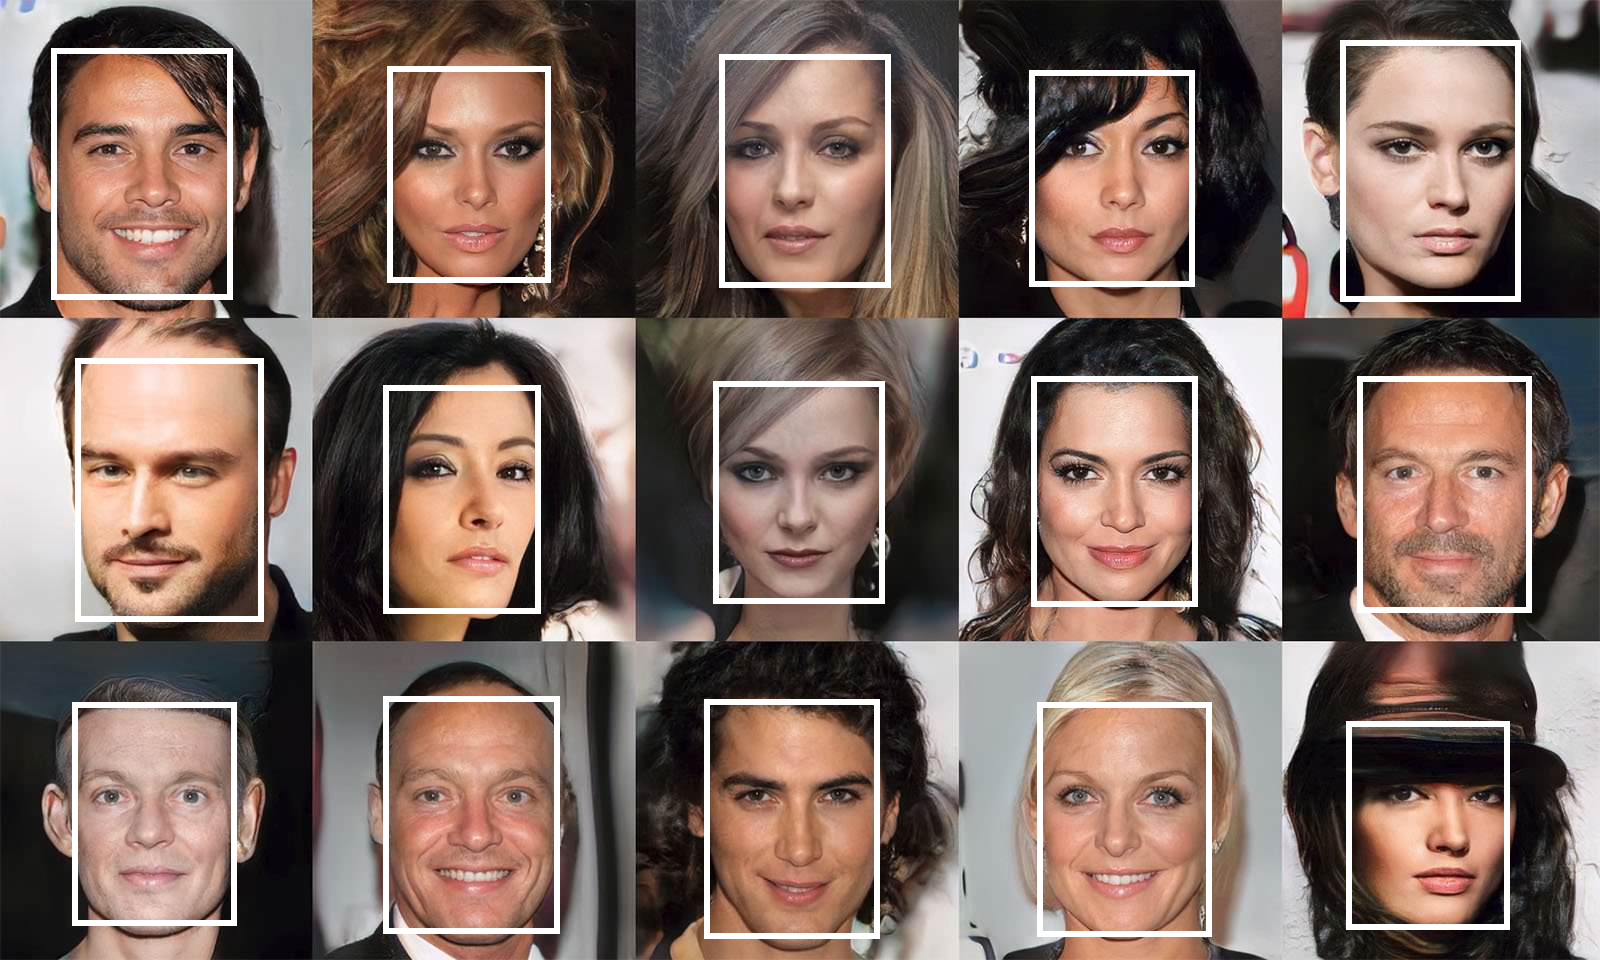

torch.Size([15, 3, 128, 128])


In [17]:
# If required, create a face detection pipeline using MTCNN:
# mtcnn = MTCNN(image_size=128, margin=5)

from PIL import Image

img = Image.open("examples/test.jpg")

# Get cropped and prewhitened image tensor
boxes, _ = mtcnn.detect(img)

img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)
if(boxes is not None):
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 255, 255), width=6)

img_draw.resize((640, 360), Image.BILINEAR)

d = display.display(img_draw, display_id=True)

img_cropped = mtcnn(img, save_path="images_detected/test.jpg")
print(img_cropped.shape)